# Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
selected_samples = iris.target < 2
x = iris.data['petal length (cm)'][selected_samples]
y = iris.target[selected_samples]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

## Create the Model from Scratch

In [3]:
class LogisticRegressionFromScratch:
    LINE_PLOT_X_LIM = [0, 5]
    LINE_PLOT_Y_LIM = [-2, 3]
    GRADIENT_PLOT_W0_LIM = [-7, 2]
    GRADIENT_PLOT_W1_LIM = [-1, 3]
    GRADIENT_PLOT_BCE_LIM = [0, 0.7]
    
    def __init__(self):
        self.w0 = 0
        self.w1 = 1

    @staticmethod
    def get_linear(x_param, w0_param, w1_param):
        return w1_param * x_param + w0_param
    
    def predict(self, x_param, w0_param=None, w1_param=None):
        """This is the Sigmoid function."""
        w0 = w0_param if w0_param else self.w0
        w1 = w1_param if w1_param else self.w1
        
        return 1 / (1 + np.exp(-self.get_linear(x_param, w0, w1)))

    def get_partial_derivative_of_binary_cross_entropy_w(self, x_param, y_param, x_j_param):
        return (self.predict(x_param) - y_param) * x_j_param

    def get_binary_cross_entropy(self, x_param, y_param, w0_param, w1_param):
        sigmoid = self.predict(x_param, w0_param, w1_param)
        
        return np.sum(
            -(y_param * np.log(sigmoid) + (1 - y_param) * np.log(1 - sigmoid))
        ) / len(y_param)

    def run_one_epoch(self, lr, x_intercept_param, x_param, y_param):
        self.w0 -= lr * np.sum(self.get_partial_derivative_of_binary_cross_entropy_w(
            x_param, y_param, x_intercept_param
        )) / len(x_param)
        self.w1 -= lr * np.sum(self.get_partial_derivative_of_binary_cross_entropy_w(
            x_param, y_param, x_param
        )) / len(x_param)

    def get_line_coordinates(self):
        line_coordinates_x = np.arange(self.LINE_PLOT_X_LIM[0], self.LINE_PLOT_X_LIM[1] + 1, 0.1)
        line_coordinates_y = self.predict(line_coordinates_x)
            
        return line_coordinates_x, line_coordinates_y
    
    def animate_line_plot(self, frame, ax1, x_param, y_param, colors, line_coordinates_x_frames,
                          line_coordinates_y_frames):
        ax1.clear()
        ax1.set_xlim(self.LINE_PLOT_X_LIM)
        ax1.set_ylim(self.LINE_PLOT_Y_LIM)
        ax1.axhline(0, color='black')
        ax1.axvline(0, color='black')
        ax1.scatter(x_param, y_param, c=colors, edgecolors='black')
        ax1.plot(line_coordinates_x_frames[frame], line_coordinates_y_frames[frame], color='red')
        ax1.set_axisbelow(True)
        ax1.grid(color='grey')
        ax1.set_title(f"Epoch: {frame + 1}")
        ax1.set_xlabel('petal length (cm)')
        ax1.set_ylabel('class')
        ax1.set_xticks(np.arange(self.LINE_PLOT_X_LIM[0], self.LINE_PLOT_X_LIM[1]))
        ax1.set_yticks(np.arange(self.LINE_PLOT_Y_LIM[0], self.LINE_PLOT_Y_LIM[1]))
    
    def create_bce_meshgrid(self, x_param, y_param):
        step = 0.1

        w0_x, w1_y = np.mgrid[
            self.GRADIENT_PLOT_W0_LIM[0]:self.GRADIENT_PLOT_W0_LIM[1]:step,
            self.GRADIENT_PLOT_W1_LIM[0]:self.GRADIENT_PLOT_W1_LIM[1]:step
        ]
        
        bce_z = np.array([
            [self.get_binary_cross_entropy(x_param, y_param, w0_x[i][j], w1_y[i][j]) 
             for j in range(w0_x.shape[1])]
            for i in range(w0_x.shape[0])
        ])
        bce_z = np.clip(bce_z, self.GRADIENT_PLOT_BCE_LIM[0], self.GRADIENT_PLOT_BCE_LIM[1])
    
        return w0_x, w1_y, bce_z
    
    def animate_gradient_plot(self, frame, ax2,  w0_frames, w1_frames, bce_frames, bce_meshgrid):
        ax2.clear()
        ax2.view_init(azim=91 + (frame / 3), elev=30)
        ax2.set_xlim(self.GRADIENT_PLOT_W0_LIM)
        ax2.set_ylim(self.GRADIENT_PLOT_W1_LIM)
        ax2.set_zlim(self.GRADIENT_PLOT_BCE_LIM)
        ax2.plot_surface(bce_meshgrid[0], bce_meshgrid[1], bce_meshgrid[2], cmap=cm.coolwarm,
                         alpha=0.5)
        ax2.scatter(w0_frames[frame], w1_frames[frame], bce_frames[frame], color='red')
        ax2.set_title((f"BCE={bce_frames[frame]:.5f} ($w_0$={w0_frames[frame]:.3f}, "
                       f"$w_1$={w1_frames[frame]:.3f})"))
        ax2.set_xlabel('$w_0$ parameter')
        ax2.set_ylabel('$w_1$ parameter')
        ax2.set_zlabel('BCE')
        ax2.set_xticks(np.arange(self.GRADIENT_PLOT_W0_LIM[0], self.GRADIENT_PLOT_W0_LIM[1]))
        ax2.set_yticks(np.arange(self.GRADIENT_PLOT_W1_LIM[0], self.GRADIENT_PLOT_W1_LIM[1]))
        ax2.set_zticks(np.arange(self.GRADIENT_PLOT_BCE_LIM[0], self.GRADIENT_PLOT_BCE_LIM[1]))
    
    def animate(self, frame, ax1, ax2, x_param, y_param, colors, line_coordinates_x_frames,
                line_coordinates_y_frames, w0_frames, w1_frames, bce_frames, bce_meshgrid):
        self.animate_line_plot(frame, ax1, x_param, y_param, colors, line_coordinates_x_frames,
                               line_coordinates_y_frames)
        self.animate_gradient_plot(frame, ax2,  w0_frames, w1_frames, bce_frames, bce_meshgrid)
    
    def fit(self, x_param, y_param, lr=0.01, epochs=100, create_animation=False):
        if len(x_param.shape) != 1:
            raise Exception(("This linear regression implementation works only with "
                             "one-dimensional features!"))

        n = len(x_param)
        x_intercept = np.ones(n)
        colors = np.where(y_param == 0, 'tab:blue', 'tab:orange')

        line_coordinates_x_frames = []
        line_coordinates_y_frames = []
        w0_frames = []
        w1_frames = []
        bce_frames = []
        
        for epoch in range(epochs):
            self.run_one_epoch(lr, x_intercept, x_param, y_param)

            if create_animation:
                line_coordinates_x, line_coordinates_y = self.get_line_coordinates()
                bce = self.get_binary_cross_entropy(x_param, y_param, self.w0, self.w1)
                
                line_coordinates_x_frames.append(line_coordinates_x)
                line_coordinates_y_frames.append(line_coordinates_y)
                w0_frames.append(self.w0)
                w1_frames.append(self.w1)
                bce_frames.append(bce)
        
        if create_animation:
            bce_meshgrid = self.create_bce_meshgrid(x_param, y_param)
    
            fig = plt.figure(figsize=plt.figaspect(2.))
            ax1 = fig.add_subplot(2, 1, 1)
            ax2 = fig.add_subplot(2, 1, 2, projection='3d')
            animation = FuncAnimation(fig, self.animate, epochs, fargs=(
                ax1, ax2, x_param, y_param, colors, line_coordinates_x_frames,
                line_coordinates_y_frames, w0_frames, w1_frames, bce_frames, bce_meshgrid
            ))
    
            fig.subplots_adjust(left=0.15, bottom=0.05, top=0.95, hspace=0.3)
            animation.save('logistic_regression.gif', writer=PillowWriter(fps=20))

## Create an Animation

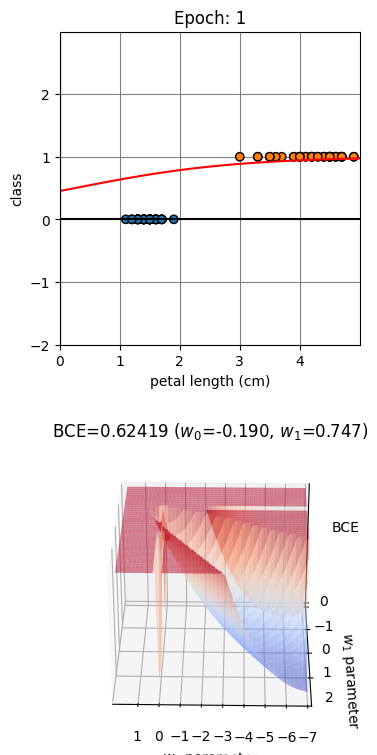

In [4]:
model_from_scratch = LogisticRegressionFromScratch()

model_from_scratch.fit(x_train, y_train, lr=0.5, epochs=180, create_animation=True)

## Compare Implementations

In [5]:
model_from_scratch = LogisticRegressionFromScratch()

model_from_scratch.fit(x_train, y_train, lr=20, epochs=1000)

y_pred = model_from_scratch.predict(x_test)

log_loss(y_test, y_pred)

7.312981291881284e-05

In [6]:
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)

In [7]:
model = LogisticRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

log_loss(y_test, y_pred)

2.220446049250313e-16